In [142]:
import pandas as pd
import numpy as np
## dataviz
import matplotlib.pyplot as plt
import seaborn as sns
## models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
## utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
# clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
from sklearn.preprocessing import OneHotEncoder
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder




In [100]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [23]:
df_original = pd.read_csv('./data/treated/21_01_2023_20_08_24_pq_leiloes.csv')

In [164]:
df_dec = df_original.drop(['auction_number','auction_item_lote','auction_item_type','auction_date','CÂMBIO MECÂNICO','FREIOS ABS',
                        'target_percentage','target_diff','auction_item_highest_bid','BLINDAGEM'],
                axis=1).copy()
df_dec = df_dec.loc[df_dec['perc_dec'] >= 0]

In [165]:
df_dec = df_dec.dropna(subset=['perc_dec'])

In [166]:
df_dec.head(5)

,auction_item_min_bid_value,auction_item_brand,auction_item_market_price,auction_item_color,auction_item_gas_type,auction_item_km,AIR BAG,ALARME,AR CONDICIONADO,CÂMBIO AUTOMÁTICO,DIREÇÃO HIDRÁULICA,TETO SOLAR,VIDRO ELÉTRICO,model_name,SEM_CHAVE,TRINCADO,AVARIADO,SINISTRO,item_age,perc_dec
0,12500.0,VW,28092.0,BRANCA,FLEX,90790.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NOVO,0.0,0.0,0.0,0.0,NaN,55.503346
1,11500.0,FIAT,25613.0,PRATA,FLEX,113718.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,UNO,0.0,0.0,0.0,0.0,NaN,55.100925
2,16000.0,CITROËN,36027.0,BRANCA,FLEX,119262.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,C3,0.0,0.0,1.0,0.0,NaN,55.588864
3,37500.0,FORD,83601.0,CINZA,FLEX,154564.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,RANGER,0.0,0.0,0.0,0.0,NaN,55.144077
4,17500.0,HYUNDAY,39484.0,PRATA,GASOLINA,149446.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,TUCSON,0.0,0.0,1.0,0.0,NaN,55.678249


In [167]:
## Setting a minimum number of brands 30
df_brands = pd.DataFrame(df_dec.auction_item_brand.value_counts()).reset_index()
df_brands.columns=['auction_item_brand','qtd']
df_brands['brand_name'] = np.where(df_brands.qtd>30,df_brands.auction_item_brand,'OUTROS')
df_brands = df_brands.drop(['qtd'],axis=1)
df_dec = df_dec.merge(df_brands,on='auction_item_brand',how='left')
df_dec = df_dec.drop(['auction_item_brand'],axis=1)

In [168]:
## Replacing values that are rare
df_dec['auction_item_gas_type'] = np.where(df_dec['auction_item_gas_type'].isin(['GAS/ALC/GNV','-','ALCOOL','GÁS','GASOLINA/GNV']),
                                            'FLEX',df_dec['auction_item_gas_type'])

In [169]:
## Setting a minimum number of colors 50
df_colors = pd.DataFrame(df_dec.auction_item_color.value_counts()).reset_index()
df_colors.columns=['auction_item_color','qtd']
df_colors['color'] = np.where(df_colors.qtd>50,df_colors.auction_item_color,'OUTROS')
df_colors = df_colors.drop(['qtd'],axis=1)
df_dec = df_dec.merge(df_colors,on='auction_item_color',how='left')
df_dec = df_dec.drop(['auction_item_color'],axis=1)

In [170]:
## Setting a minimum number of models 20
df_models = pd.DataFrame(df_dec.model_name.value_counts()).reset_index()
df_models.columns=['model_name','qtd']
df_models['model'] = np.where(df_models.qtd>20,df_models.model_name,'OUTROS')
df_models = df_models.drop(['qtd'],axis=1)
df_dec = df_dec.merge(df_models,on='model_name',how='left')
df_dec = df_dec.drop(['model_name'],axis=1)

### One Hot Encoding

In [171]:
df_dec = pd.get_dummies(df_dec, columns = ['brand_name',	'color',	'model' ,'auction_item_gas_type'],drop_first=True)

In [172]:
df_dec.head()

,auction_item_min_bid_value,auction_item_market_price,auction_item_km,AIR BAG,ALARME,AR CONDICIONADO,CÂMBIO AUTOMÁTICO,DIREÇÃO HIDRÁULICA,TETO SOLAR,VIDRO ELÉTRICO,SEM_CHAVE,TRINCADO,AVARIADO,SINISTRO,item_age,perc_dec,brand_name_FIAT,brand_name_FORD,brand_name_GM,brand_name_HONDA,brand_name_HYUNDAY,brand_name_JAC,brand_name_JEEP,brand_name_MERCEDES BENZ,brand_name_MMC,brand_name_NISSAN,brand_name_OUTROS,brand_name_PEUGEOT,brand_name_RENAULT,brand_name_TOYOTA,brand_name_VW,brand_name_YAMAHA,color_BRANCA,color_CINZA,color_OUTROS,color_PRATA,color_PRETA,color_VERMELHA,model_208,model_ARGO,model_C3,model_CELTA,model_CG,model_CIVIC,model_CLASSIC,model_COMPASS,model_COROLLA,model_CRUZE,model_DUSTER,model_ECOSPORT,model_FIESTA,model_FIT,model_FOCUS,model_FOX,model_FUSION,model_GOL,model_HB20,model_HB20S,model_J3,model_KA,model_KWID,model_LOGAN,model_NOVO,model_ONIX,model_OUTROS,model_PALIO,model_POLO,model_PRISMA,model_RANGER,model_RENEGADE,model_S10,model_SANDERO,model_SANTA,model_SAVEIRO,model_SIENA,model_SPIN,model_STRADA,model_UNO,model_VERSA,model_VIRTUS,model_VOYAGE,auction_item_gas_type_FLEX,auction_item_gas_type_GASOLINA
0,12500.0,28092.0,90790.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,55.503346,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,11500.0,25613.0,113718.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,55.100925,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,16000.0,36027.0,119262.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,55.588864,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,37500.0,83601.0,154564.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,55.144077,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,17500.0,39484.0,149446.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,55.678249,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Filling missing

In [251]:
class filling_na():
    def __init__(self):
        self.parameter = {}

    def fit(self,df,y=None):
        ## Filling with mean value
        for c in ['auction_item_km','item_age']:
            self.parameter[c] = df[c].mean()
        ## Filling na with round mean value
        for c in ['AIR BAG','ALARME','AR CONDICIONADO','CÂMBIO AUTOMÁTICO','DIREÇÃO HIDRÁULICA','TETO SOLAR','VIDRO ELÉTRICO']:
            self.parameter[c] = round(df[c].mean())

    def fit_transform(self,df,y=None):
        ## Filling with mean value
        for c in ['auction_item_km','item_age']:
            self.parameter[c] = df[c].mean()
            df[c]  = df[c].fillna(self.parameter[c])
        ## Filling na with round mean value
        for c in ['AIR BAG','ALARME','AR CONDICIONADO','CÂMBIO AUTOMÁTICO','DIREÇÃO HIDRÁULICA','TETO SOLAR','VIDRO ELÉTRICO']:
            self.parameter[c] = round(df[c].mean())
            df[c] = df[c].fillna(self.parameter[c])
        return df

    def transform(self,df,y=None):
        ## Filling with mean value
        for c in ['auction_item_km','item_age']:
            df[c]  = df[c].fillna(self.parameter[c])
        ## Filling na with round mean value
        for c in ['AIR BAG','ALARME','AR CONDICIONADO','CÂMBIO AUTOMÁTICO','DIREÇÃO HIDRÁULICA','TETO SOLAR','VIDRO ELÉTRICO']:
            df[c] = df[c].fillna(self.parameter[c])
        return df

In [252]:
filler = filling_na()
filler.fit(df_dec)

### Boxcox for linear model

In [253]:
class boxcox_pipe():
    def __init__(self,lmb= None):
        self.lmb = lmb
    
    def fit(self,X,Y):
        _, self.lmb = boxcox(Y)
    def fit_transform(self,X,Y):
        Y, self.lmb = boxcox(Y)
        return X, Y
    def transform(self,X,Y):
        return X, boxcox(Y,lmbda=self.lmb)
    def invert(self,Y):
        return inv_boxcox(Y,self.lmb)

In [254]:
bp = boxcox_pipe()

### Splitting dataframe

In [268]:
df_train, df_valid = train_test_split(df_dec, test_size=0.3,  random_state=RS)

### Linear model - boxcox

In [297]:
df_train_lm, df_valid_lm = df_train.copy(), df_valid.copy()

In [298]:
_, df_train_lm.perc_dec = bp.fit_transform('',df_train_lm.perc_dec)

In [299]:
cv = 2
clf_lm = make_pipeline(filling_na(),LinearRegression() )
# scores = cross_validate(clf_lm, df_dec.drop(['perc_dec'],axis=1), df_dec.perc_dec, cv=cv,
#                             return_train_score = True, return_estimator = True)

In [300]:
clf_lm.fit(df_train_lm.drop(['perc_dec'],axis=1), df_train_lm.perc_dec)

Pipeline(steps=[('filling_na',
                 <__main__.filling_na object at 0x0000020DBCF49668>),
                ('linearregression', LinearRegression())])

In [301]:
df_train_lm['lm_fit'] = clf_lm.predict(df_train_lm.drop(['perc_dec'],axis=1))

In [302]:
r2_score(df_train_lm.perc_dec,df_train_lm.lm_fit)

0.45430762864835095

In [303]:
df_valid_lm['lm_fit'] = clf_lm.predict(df_valid_lm.drop(['perc_dec'],axis=1))

In [304]:
df_valid_lm['lm_fit'] = bp.invert(df_valid_lm['lm_fit'])

In [305]:
r2_score(df_valid_lm.perc_dec,df_valid_lm.lm_fit)

0.477104280348418

In [306]:
clf_lm[1].coef_

array([-8.56427079e-05,  5.28111484e-05,  2.28209753e-06, -2.90062410e-01,
       -3.57057533e-03, -3.57712167e-01, -2.78167540e-01, -7.29099698e-02,
        1.13199166e-01, -1.17196009e-01,  3.13306185e-01,  2.21550537e-01,
        4.53328589e-01,  1.01153425e+00,  2.63308287e-02, -1.04967956e+00,
       -1.15901689e+00, -1.73642125e-01, -1.63374617e+00, -1.06840948e+00,
        1.04312891e+00, -1.97737187e+00, -1.84815204e-01, -9.36633190e-01,
       -3.23429279e-01, -5.43922915e-01,  3.90449475e-01,  1.06058749e-01,
       -1.40760446e+00, -4.51999383e-01, -1.45087255e+00,  3.11984317e-02,
        1.15552644e-01,  2.00612300e-02,  5.27956700e-02,  4.72296302e-01,
       -5.60038305e-02,  5.99074806e-02,  1.39065457e+00,  1.71292146e+00,
       -8.74466529e-02,  1.74000654e+00,  1.72557108e+00,  7.97509677e-01,
        2.88601311e+00,  1.65487110e+00,  9.50008607e-01,  1.47848198e-01,
        1.47866724e+00,  2.35087336e+00,  1.84913795e+00,  2.25750599e+00,
        7.96460671e-01,  

In [307]:
clf_lm[1].intercept_

7.867186854731642

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='perc_dec', ylabel='lm_fit'>

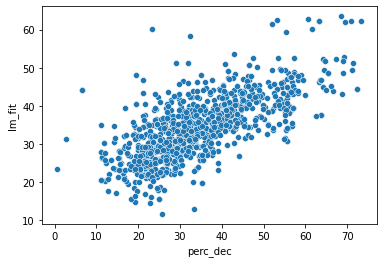

In [308]:
sns.scatterplot(df_valid_lm.perc_dec,df_valid_lm.lm_fit)

### Linear model - plain

In [286]:
df_train_lm, df_valid_lm = df_train.copy(), df_valid.copy()

In [288]:
clf_lm = make_pipeline(filling_na(),LinearRegression() )

In [289]:
clf_lm.fit(df_train_lm.drop(['perc_dec'],axis=1), df_train_lm.perc_dec)

Pipeline(steps=[('filling_na',
                 <__main__.filling_na object at 0x0000020DC2570358>),
                ('linearregression', LinearRegression())])

In [290]:
df_train_lm['lm_fit'] = clf_lm.predict(df_train_lm.drop(['perc_dec'],axis=1))

In [291]:
r2_score(df_train_lm.perc_dec,df_train_lm.lm_fit)

0.4726532055837437

In [292]:
df_valid_lm['lm_fit'] = clf_lm.predict(df_valid_lm.drop(['perc_dec'],axis=1))

In [293]:
r2_score(df_valid_lm.perc_dec,df_valid_lm.lm_fit)

0.4671060408663614

In [294]:
clf_lm[1].coef_

array([-5.70481841e-04,  3.49512275e-04,  1.48634733e-05, -2.09207671e+00,
       -3.12163737e-01, -2.52291701e+00, -1.54041023e+00, -6.15044475e-01,
        7.70052578e-01, -6.27485713e-01,  2.12821364e+00,  1.33433104e+00,
        3.10318743e+00,  6.31691215e+00,  1.61894942e-01, -6.83858673e+00,
       -7.19066253e+00, -1.19740823e+00, -1.00596715e+01, -7.02467940e+00,
        8.64467022e+00, -1.39131674e+01, -7.60665687e-01, -5.92716255e+00,
       -1.51207170e+00, -3.20434948e+00,  2.85527503e+00,  1.20733023e+00,
       -8.06150214e+00, -2.68876205e+00, -1.01044249e+01,  2.30940910e-01,
        7.43424999e-01,  2.00545331e-01,  4.39168420e-01,  3.19811681e+00,
       -5.37048630e-01,  2.07116126e-01,  9.13031560e+00,  1.09454736e+01,
       -8.79325347e-01,  1.05474762e+01,  1.00682162e+01,  4.56848008e+00,
        2.07163427e+01,  1.06089017e+01,  5.44191632e+00,  5.19448350e-02,
        8.89124517e+00,  1.50206782e+01,  1.13811977e+01,  1.41909617e+01,
        4.55767160e+00,  

In [295]:
clf_lm[1].intercept_

28.351975370106466

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='perc_dec', ylabel='lm_fit'>

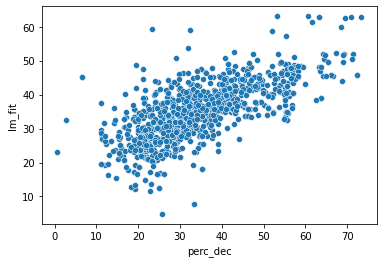

In [296]:
sns.scatterplot(df_valid_lm.perc_dec,df_valid_lm.lm_fit)

### Ligthgbm

In [331]:
df_train_light, df_valid_light = df_train.copy(), df_valid.copy()

In [332]:
cv = 5
clf_lm = make_pipeline(filling_na(),LGBMRegressor(random_state=RS) )
scores = cross_validate(clf_lm, df_train_light.drop(['perc_dec'],axis=1), df_train_light.perc_dec, cv=cv,
                            return_train_score = True, return_estimator = True)

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [333]:
scores

{'fit_time': array([0.23398161, 0.08950925, 0.07562852, 0.11420465, 0.09295774]),
 'score_time': array([0.008147  , 0.00598383, 0.00717187, 0.0071876 , 0.0069809 ]),
 'estimator': (Pipeline(steps=[('filling_na',
                   <__main__.filling_na object at 0x0000020DC271DD68>),
                  ('lgbmregressor', LGBMRegressor(random_state=42))]),
  Pipeline(steps=[('filling_na',
                   <__main__.filling_na object at 0x0000020DC2740710>),
                  ('lgbmregressor', LGBMRegressor(random_state=42))]),
  Pipeline(steps=[('filling_na',
                   <__main__.filling_na object at 0x0000020DBDD09DA0>),
                  ('lgbmregressor', LGBMRegressor(random_state=42))]),
  Pipeline(steps=[('filling_na',
                   <__main__.filling_na object at 0x0000020DC27151D0>),
                  ('lgbmregressor', LGBMRegressor(random_state=42))]),
  Pipeline(steps=[('filling_na',
                   <__main__.filling_na object at 0x0000020DC27F4860>),
            

In [334]:
df_train_light['light_fit'] = scores['estimator'][0].predict(df_train_light.drop(['perc_dec'],axis=1))

In [335]:
r2_score(df_train_light.perc_dec,df_train_light.light_fit)

0.8394486280045252

In [336]:
df_valid_light['light_fit'] = scores['estimator'][0].predict(df_valid_light.drop(['perc_dec'],axis=1))

In [337]:
r2_score(df_valid_light.perc_dec,df_valid_light.light_fit)

0.6586404199491684

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='perc_dec', ylabel='light_fit'>

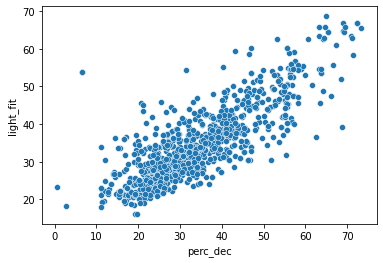

In [338]:
sns.scatterplot(df_valid_light.perc_dec,df_valid_light.light_fit)

In [342]:
scores['estimator'][0][1].feature_importances_

array([501, 618, 557,  37,  54,  22,  36,   9,  11,  18,   9,  21,  35,
        47, 512,  39,  14,  23,  14,  11,   4,   6,   8,   1,   5,  13,
        15,  13,  17,  15,   0,  26,  15,   4,  34,  30,   5,   0,   0,
         0,  10,   2,   0,   2,   0,   0,   0,   0,   0,   5,   0,   0,
         0,   0,  18,  10,   0,   0,   4,   0,   0,  15,   6,  56,   2,
         0,   0,   0,   0,   4,   0,   0,   0,  10,   0,   5,  15,   0,
         0,   2,  20,  15])

In [344]:
df_train.columns

Index(['auction_item_min_bid_value', 'auction_item_market_price',
       'auction_item_km', 'AIR BAG', 'ALARME', 'AR CONDICIONADO',
       'CÂMBIO AUTOMÁTICO', 'DIREÇÃO HIDRÁULICA', 'TETO SOLAR',
       'VIDRO ELÉTRICO', 'SEM_CHAVE', 'TRINCADO', 'AVARIADO', 'SINISTRO',
       'item_age', 'perc_dec', 'brand_name_FIAT', 'brand_name_FORD',
       'brand_name_GM', 'brand_name_HONDA', 'brand_name_HYUNDAY',
       'brand_name_JAC', 'brand_name_JEEP', 'brand_name_MERCEDES BENZ',
       'brand_name_MMC', 'brand_name_NISSAN', 'brand_name_OUTROS',
       'brand_name_PEUGEOT', 'brand_name_RENAULT', 'brand_name_TOYOTA',
       'brand_name_VW', 'brand_name_YAMAHA', 'color_BRANCA', 'color_CINZA',
       'color_OUTROS', 'color_PRATA', 'color_PRETA', 'color_VERMELHA',
       'model_208', 'model_ARGO', 'model_C3', 'model_CELTA', 'model_CG',
       'model_CIVIC', 'model_CLASSIC', 'model_COMPASS', 'model_COROLLA',
       'model_CRUZE', 'model_DUSTER', 'model_ECOSPORT', 'model_FIESTA',
       'model_FIT',

### XGBoost

In [345]:
df_train_xgb, df_valid_xgb = df_train.copy(), df_valid.copy()

In [346]:
cv = 5
clf_lm = make_pipeline(filling_na(),XGBRegressor(random_state=RS) )
scores = cross_validate(clf_lm, df_train_xgb.drop(['perc_dec'],axis=1), df_train_xgb.perc_dec, cv=cv,
                            return_train_score = True, return_estimator = True)

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [347]:
scores

{'fit_time': array([1.72311616, 0.1466589 , 0.16968346, 0.15972686, 0.15235162]),
 'score_time': array([0.00772238, 0.00870204, 0.00855541, 0.00925875, 0.00732684]),
 'estimator': (Pipeline(steps=[('filling_na',
                   <__main__.filling_na object at 0x0000020DBDEA5D30>),
                  ('xgbregressor',
                   XGBRegressor(base_score=0.5, booster='gbtree',
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints='',
                                learning_rate=0.300000012, max_delta_step=0,
                                max_depth=6, min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=100,
                                n_jobs=0, num_parallel_tree=1, random_state=42,
                                reg_alpha=

In [348]:
df_train_xgb['xgb_fit'] = scores['estimator'][0].predict(df_train_xgb.drop(['perc_dec'],axis=1))

In [350]:
r2_score(df_train_xgb.perc_dec,df_train_xgb.xgb_fit)

0.9188435151610848

In [351]:
df_valid_xgb['xgb_fit'] = scores['estimator'][0].predict(df_valid_xgb.drop(['perc_dec'],axis=1))

In [352]:
r2_score(df_valid_xgb.perc_dec,df_valid_xgb.xgb_fit)

0.6436057028958636

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='perc_dec', ylabel='xgb_fit'>

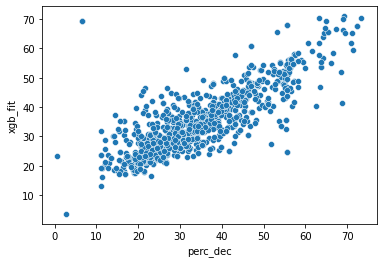

In [353]:
sns.scatterplot(df_valid_xgb.perc_dec,df_valid_xgb.xgb_fit)

In [354]:
scores['estimator'][0][1].feature_importances_

array([0.01163236, 0.01258365, 0.01242097, 0.02359527, 0.01326594,
       0.01896462, 0.0058291 , 0.01294824, 0.00578399, 0.00958553,
       0.03404789, 0.00580318, 0.01132977, 0.0274378 , 0.03163091,
       0.02159513, 0.01492448, 0.02210162, 0.01978418, 0.00710141,
       0.01548073, 0.00596756, 0.00788319, 0.01445267, 0.01098308,
       0.03648897, 0.00500928, 0.01122078, 0.01396042, 0.01303266,
       0.00257073, 0.00853882, 0.00906764, 0.00381442, 0.01598826,
       0.01199106, 0.0093099 , 0.00315337, 0.00207984, 0.01343204,
       0.01178884, 0.00500867, 0.00468879, 0.00336217, 0.00438422,
       0.02412815, 0.01129664, 0.00384333, 0.00470325, 0.00664749,
       0.01945311, 0.00823365, 0.01315439, 0.00842896, 0.00772315,
       0.0145397 , 0.00214425, 0.01613276, 0.02467881, 0.00188267,
       0.00296094, 0.02051536, 0.00845377, 0.01632131, 0.01187533,
       0.00933366, 0.0103061 , 0.00460761, 0.        , 0.02216745,
       0.00464289, 0.02915654, 0.00782661, 0.01066985, 0.01624

In [355]:
df_valid_xgb.columns

Index(['auction_item_min_bid_value', 'auction_item_market_price',
       'auction_item_km', 'AIR BAG', 'ALARME', 'AR CONDICIONADO',
       'CÂMBIO AUTOMÁTICO', 'DIREÇÃO HIDRÁULICA', 'TETO SOLAR',
       'VIDRO ELÉTRICO', 'SEM_CHAVE', 'TRINCADO', 'AVARIADO', 'SINISTRO',
       'item_age', 'perc_dec', 'brand_name_FIAT', 'brand_name_FORD',
       'brand_name_GM', 'brand_name_HONDA', 'brand_name_HYUNDAY',
       'brand_name_JAC', 'brand_name_JEEP', 'brand_name_MERCEDES BENZ',
       'brand_name_MMC', 'brand_name_NISSAN', 'brand_name_OUTROS',
       'brand_name_PEUGEOT', 'brand_name_RENAULT', 'brand_name_TOYOTA',
       'brand_name_VW', 'brand_name_YAMAHA', 'color_BRANCA', 'color_CINZA',
       'color_OUTROS', 'color_PRATA', 'color_PRETA', 'color_VERMELHA',
       'model_208', 'model_ARGO', 'model_C3', 'model_CELTA', 'model_CG',
       'model_CIVIC', 'model_CLASSIC', 'model_COMPASS', 'model_COROLLA',
       'model_CRUZE', 'model_DUSTER', 'model_ECOSPORT', 'model_FIESTA',
       'model_FIT',

### Random Forest

In [356]:
df_train_rfr, df_valid_rfr = df_train.copy(), df_valid.copy()

In [357]:
cv = 5
clf_lm = make_pipeline(filling_na(),RandomForestRegressor(random_state=RS) )
scores = cross_validate(clf_lm, df_train_rfr.drop(['perc_dec'],axis=1), df_train_rfr.perc_dec, cv=cv,
                            return_train_score = True, return_estimator = True)

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [358]:
scores

{'fit_time': array([1.25269175, 1.34567499, 1.18020082, 1.18602991, 1.24177957]),
 'score_time': array([0.02586079, 0.01703978, 0.01847458, 0.01838279, 0.02227378]),
 'estimator': (Pipeline(steps=[('filling_na',
                   <__main__.filling_na object at 0x0000020DC25D9048>),
                  ('randomforestregressor',
                   RandomForestRegressor(random_state=42))]),
  Pipeline(steps=[('filling_na',
                   <__main__.filling_na object at 0x0000020DC1E44DA0>),
                  ('randomforestregressor',
                   RandomForestRegressor(random_state=42))]),
  Pipeline(steps=[('filling_na',
                   <__main__.filling_na object at 0x0000020DBFDB4EB8>),
                  ('randomforestregressor',
                   RandomForestRegressor(random_state=42))]),
  Pipeline(steps=[('filling_na',
                   <__main__.filling_na object at 0x0000020DBDF7B860>),
                  ('randomforestregressor',
                   RandomForestRegresso

In [359]:
df_train_rfr['rfr_fit'] = scores['estimator'][0].predict(df_train_rfr.drop(['perc_dec'],axis=1))

In [360]:
r2_score(df_train_rfr.perc_dec,df_train_rfr.rfr_fit)

0.8932871069254019

In [361]:
df_valid_rfr['rfr_fit'] = scores['estimator'][0].predict(df_valid_rfr.drop(['perc_dec'],axis=1))

In [362]:
r2_score(df_valid_rfr.perc_dec,df_valid_rfr.rfr_fit)

0.676945546061578

c:\Users\gabri\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='perc_dec', ylabel='rfr_fit'>

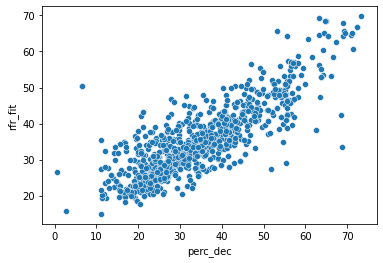

In [363]:
sns.scatterplot(df_valid_rfr.perc_dec,df_valid_rfr.rfr_fit)

In [364]:
scores['estimator'][0][1].feature_importances_

array([1.45606022e-01, 1.46900109e-01, 1.24634617e-01, 7.87511172e-03,
       1.11122167e-02, 6.48917549e-03, 6.76703843e-03, 4.53903532e-03,
       4.93202501e-03, 4.98581243e-03, 9.21760026e-03, 6.84394690e-03,
       1.35428729e-02, 1.40747140e-02, 3.04989009e-01, 9.99881326e-03,
       3.64023824e-03, 7.86843175e-03, 1.39896889e-03, 3.30337250e-03,
       2.65211061e-03, 6.48004443e-04, 3.76681880e-03, 2.13529649e-03,
       3.36689251e-03, 7.09796096e-03, 1.76399068e-03, 3.82054292e-03,
       3.79740024e-03, 7.11737617e-03, 5.68957764e-04, 6.81527270e-03,
       5.38352218e-03, 4.72640014e-03, 1.08495243e-02, 1.06096041e-02,
       3.46927468e-03, 6.04439207e-04, 5.65458731e-04, 1.58084541e-03,
       3.62343130e-03, 2.39837340e-04, 1.27208000e-04, 9.63354249e-04,
       2.65192583e-04, 1.61958045e-03, 6.88749202e-04, 4.74439046e-04,
       1.23191338e-03, 3.19553404e-03, 4.89176598e-04, 5.05364797e-04,
       1.41552017e-03, 2.06536354e-04, 6.04157299e-03, 9.65865998e-04,
      

In [365]:
df_valid_xgb.columns

Index(['auction_item_min_bid_value', 'auction_item_market_price',
       'auction_item_km', 'AIR BAG', 'ALARME', 'AR CONDICIONADO',
       'CÂMBIO AUTOMÁTICO', 'DIREÇÃO HIDRÁULICA', 'TETO SOLAR',
       'VIDRO ELÉTRICO', 'SEM_CHAVE', 'TRINCADO', 'AVARIADO', 'SINISTRO',
       'item_age', 'perc_dec', 'brand_name_FIAT', 'brand_name_FORD',
       'brand_name_GM', 'brand_name_HONDA', 'brand_name_HYUNDAY',
       'brand_name_JAC', 'brand_name_JEEP', 'brand_name_MERCEDES BENZ',
       'brand_name_MMC', 'brand_name_NISSAN', 'brand_name_OUTROS',
       'brand_name_PEUGEOT', 'brand_name_RENAULT', 'brand_name_TOYOTA',
       'brand_name_VW', 'brand_name_YAMAHA', 'color_BRANCA', 'color_CINZA',
       'color_OUTROS', 'color_PRATA', 'color_PRETA', 'color_VERMELHA',
       'model_208', 'model_ARGO', 'model_C3', 'model_CELTA', 'model_CG',
       'model_CIVIC', 'model_CLASSIC', 'model_COMPASS', 'model_COROLLA',
       'model_CRUZE', 'model_DUSTER', 'model_ECOSPORT', 'model_FIESTA',
       'model_FIT',